## Scenario Hurricane Risk Analysis

In [1]:
# Importing Necessary Dependencies
import warnings
import collections
import concurrent.futures
import folium
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from scipy.stats import expon, lognorm
from scipy.spatial import distance
from past.builtins import xrange
import tcra
from tcra.Cyclone import CycloneParameters
from tcra.Vulnerability import FragilityAnalysis
from tcra.DamageProbability import DamageProbabilityCalculator
from tcra.Fragility import rehab_fragility_curves, fragility_curves_epn, fragility_curves
from tcra.Plot import plot_scatter
from tcra.Probplot import plot_lognormal_distribution
from tcra.Interactive import plot_interactive_map
from tcra.Recovery import rep, rep_EPN, recovery_monte_carlo_simulation
from tcra.Cost import map_cost
from tcra.DR import damage_ratio
from typing import List

### 1. Hurricane Track Import, Building Data Import, Estimating Peak Velocity

In [2]:
# Import Hurricane Historical Track
track_df=pd.read_csv('91_Track1.csv')

In [3]:
# this data includes time, lat, long and central pressure
track_df.head(2)

Sl  Time    Lat   Long      CP
0   1   0.0  17.40  88.90  934.00
1   2   0.5  17.48  88.94  932.83

In [4]:
# Import Building Data
blg=pd.read_csv('sample_buildings.csv')

In [5]:
# Inventory Size
blg.shape

(9735, 7)

In [6]:
# structuretype_counts=blg.type.value_counts()
# structuretype_counts.plot(kind='bar')
# plt.xlabel('Occupancy Type')
# plt.ylabel('%Buildings')
# plt.show()

In [7]:
# occupancy_counts = blg.Occupancy.value_counts(normalize=True)
# occupancy_counts.plot(kind='bar')
# plt.xlabel('Occupancy Type')
# plt.ylabel('%Buildings')
# plt.show()

In [8]:
blg.head(2)

id          x          y  Floor Occupancy   type      area
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702

#### Scenario Hurricane - Wind Speed Simulation

In [9]:
# Running wind hazard module to estimate Cyclone track characteristics and Wind Speeds
# df_bdg_wind: database return with wind speed, VG: gust wind velocity
cyclone_parameters = CycloneParameters(track_df)
df_track = cyclone_parameters.estimate_parameters()
df_bdg_wind, VG = cyclone_parameters.calculate_wind_speeds(df_track, blg)

In [10]:
df_bdg_wind.head(2)

id          x          y  Floor Occupancy   type      area  ind         mph
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510    1  155.249975
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702    2  155.246906

In [11]:
df_bdg_wind.shape

(9735, 9)

In [12]:
df_bdg_wind.drop(['ind'], axis=1, inplace=True)

#### Plotting Peak Gust Wind Speed - All Structuras

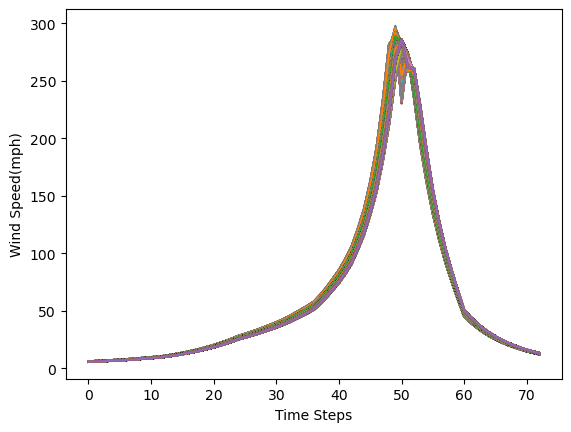

In [13]:
VG.plot.line(legend=None)
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed(mph)')
plt.savefig('Cyclone_Hazard_Buildings.png', dpi=300)
plt.show()

### 2. Vulnerability Analysis - Damage States Simulation

In [14]:
# Assign random seed to reproduce random numbers
seed=1234
np.random.seed(seed)

In [15]:
# Building invetory dataframe
df_bdg_wind.head(2)

id          x          y  Floor Occupancy   type      area         mph
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  155.249975
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  155.246906

In [16]:
building_data = df_bdg_wind

In [17]:
# Defining Damage States - four damage states as per HAZUS (FEMA)
DStates=['Slight','Moderate','Extensive', 'Complete']

In [18]:
# Running Vulnerability Analysis based on Fragility Curves to assign Damage States to Structures
fra= FragilityAnalysis(fragility_curves)
Pr = fra.estimate_damage_state(building_data)
damage_state = fra.sample_damage_state(Pr, DStates,seed)

In [19]:
# Mapping Damage States [DStates] to Structures
DamageStateMap = {None: 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}
damage_state = damage_state.map(DamageStateMap)

In [20]:
# Adding columns to estimate damage State Probabilities (LS: Limit State, DS: Damage State)
DS_Prob=Pr
DS_Prob['LS1'] = DS_Prob['Slight']
DS_Prob['LS2'] = DS_Prob['Moderate']
DS_Prob['LS3'] = DS_Prob['Extensive']
DS_Prob['LS4'] = DS_Prob['Complete']
DS_Prob['DS0'] = 1 - DS_Prob['Slight']
DS_Prob['DS1'] = DS_Prob['Slight'] - DS_Prob['Moderate']
DS_Prob['DS2'] = DS_Prob['Moderate'] - DS_Prob['Extensive']
DS_Prob['DS3'] = DS_Prob['Extensive'] - DS_Prob['Complete']
DS_Prob['DS4'] = DS_Prob['Complete']

In [21]:
DS_Prob.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy       LS1       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  0.791333  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  0.825029  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01

In [22]:
#Cleaning the database
# DS_Prob.drop(['Slight','Moderate','Extensive','Complete'], axis=1, inplace=True)

In [23]:
# Merging Assigned Damage States (dmg) and DS probabilities to structure inventory
s = pd.Series(damage_state,name='dmg')
result_blg_damage= DS_Prob.join(s)

In [24]:
result_blg_damage.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy       LS1       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  0.791333  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  0.825029  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4  dmg  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08    3  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01    2

#### Plotting Wind Speed and Damage States

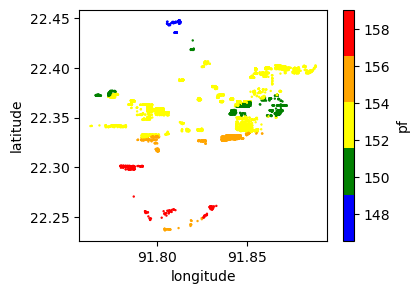

In [25]:
# plotting wind speed
plot_scatter(result_blg_damage, 'x', 'y', 'mph', save_path='wind_speed.png')

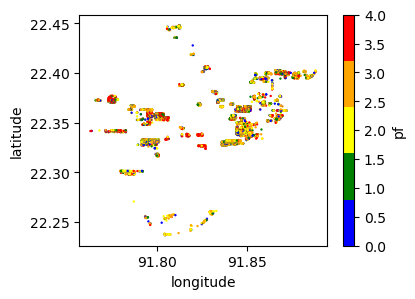

In [26]:
# plotting damage states
plot_scatter(result_blg_damage, 'x', 'y', 'dmg', save_path='blg_dmg_states_unrehab.png')

### 3. Failure Probability Estimation - Monte Carlo Simulation

In [27]:
# Inventory results from Hazard and Vulnerability Analyses
result_blg_damage.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy       LS1       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  0.791333  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  0.825029  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4  dmg  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08    3  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01    2

In [28]:
# Defining Damage Intervals and Failure State (i.e., DS3 and DS4 will considered failure)
bldg_result=result_blg_damage 
damage_interval_keys=['DS0', 'DS1', 'DS2', 'DS3', 'DS4']
failure_state_keys=['DS3', 'DS4']
num_samples=10

In [29]:
# Estimating Failure Probabilites
calculator = DamageProbabilityCalculator(failure_state_keys)
dt, ki = calculator.sample_damage_interval(bldg_result, damage_interval_keys, num_samples, seed)

In [30]:
# covert result to dataframe
df_bldg = pd.DataFrame({'id': ki,'pf': dt})

In [31]:
df_bldg.head(2)

id   pf
0   1  0.5
1   2  0.6

In [32]:
# Merging failure probability to structural inventory data
result_bldg=pd.merge(result_blg_damage, df_bldg, on='id')

In [33]:
result_bldg.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy  ...       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  ...  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  ...  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4  dmg   pf  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08    3  0.5  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01    2  0.6  

[2 rows x 21 columns]

#### PlottingProbability of Failure

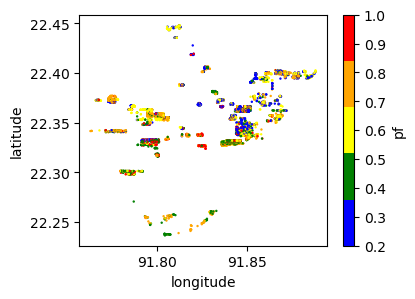

In [34]:
# plotting damage failure probability
plot_scatter(result_bldg, 'x', 'y', 'pf', save_path='blg_Dmg.png')

#### Fitting Failure Probabilities to Lognormal Distribution

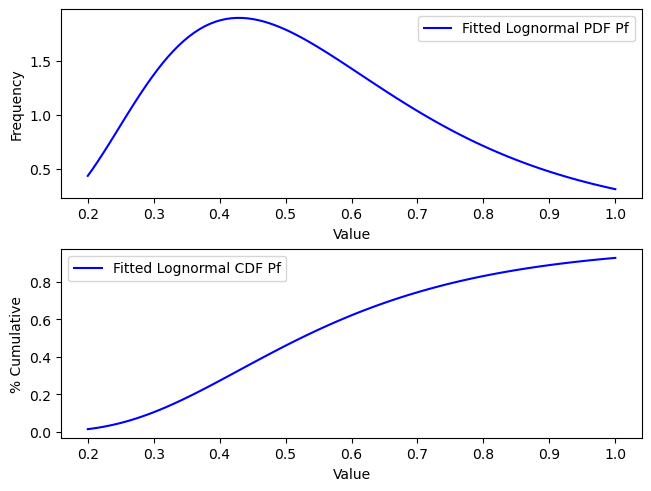

In [35]:
# Plotting fitted lognormal PDF & CDF of prob. of failure
plot_lognormal_distribution(result_bldg)

### 4. Loss Estimation - Damage Repair Cost

In [36]:
# Calculating replacement cost of individual building, UC: Unit Cost and RCost: Replacement Cost
df_cost = map_cost(blg)

In [37]:
df_cost.head(2)

id          x          y  Floor Occupancy   type      area     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  780.0   

        RCost  
0    8279.519  
1  395982.756

In [38]:
# Merging cost and damage outputs
s = pd.Series(damage_state,name='dmg')
df_cost_dmg= df_cost.join(s)

In [39]:
# Generating Damage Ratio of each building
Loss = damage_ratio(df_cost_dmg)

In [40]:
# Estimating Physical Damage Repair Cost ($) for each building
Loss['PhyLoss']=Loss['RCost']*Loss['DRatio']

In [41]:
#### Estimated Loss due to Physical Damage in $USD
TotalPhyLoss=Loss.PhyLoss.sum()
TotalPhyLoss

6577903788.94597

### 5. Recovery Simulations

In [42]:
result_bldg.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy  ...       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  ...  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  ...  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4  dmg   pf  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08    3  0.5  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01    2  0.6  

[2 rows x 21 columns]

In [43]:
# Simulating Recovery Time of Buildings
recovery_time = rep(result_bldg)
result_bldg['RT_bdg'] = list(recovery_time)

In [44]:
result_bldg.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy  ...       LS3           LS4       DS0  \
0  155.249975  CERBL      COM1  ...  0.232671  1.590785e-08  0.208667   
1  155.246906  MLRM1      COM1  ...  0.409808  1.607358e-01  0.174971   

        DS1       DS2       DS3           DS4  dmg   pf      RT_bdg  
0  0.216464  0.342197  0.232671  1.590785e-08    3  0.5  252.704084  
1  0.125692  0.289529  0.249072  1.607358e-01    2  0.6  121.134460  

[2 rows x 22 columns]

In [45]:
bb = []
tt = list(range(0, 1000, 5))
for T in tt:
    bb.append(result_bldg[result_bldg.RT_bdg < T].shape[0])

In [46]:
bb=pd.Series(bb)*100/result_bldg.shape[0]

In [47]:
x = list(tt)
y1 = list(bb)
rec_bldg=pd.DataFrame({'T': x,'Rec': y1})

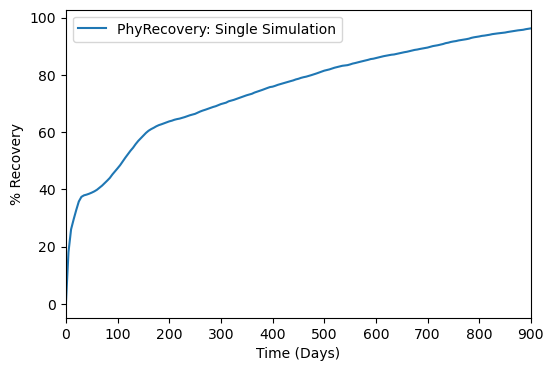

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(x, y1, label='PhyRecovery: Single Simulation')
plt.xlabel("Time (Days)")
plt.ylabel("% Recovery")
plt.legend()
plt.xlim(0, 900)
plt.show()

In [49]:
# Recovery Analysis - Multiple Recovery Scenarios using Monte Carlo Simulation
x, all_simulations, mean, minimum, maximum = recovery_monte_carlo_simulation(result_bldg, num_simulations=100)

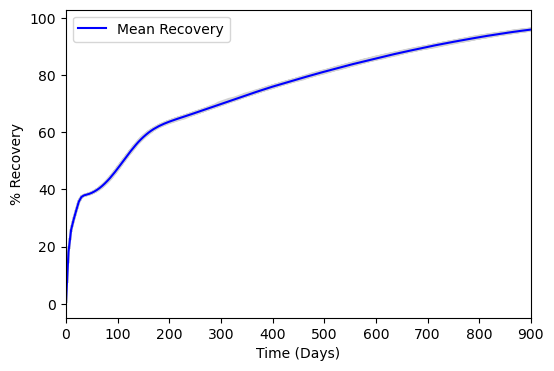

In [50]:
# Plotting all simulations results
plt.figure(figsize=(6, 4))
for simulation in all_simulations:
    plt.plot(x, simulation, color='lightgray', alpha=1)
plt.plot(x, mean, color='blue', label='Mean Recovery')
plt.xlabel("Time (Days)")
plt.ylabel("% Recovery")
plt.legend()
plt.xlim(0, 900)
plt.show()

### 6. Rahab Simulation

#### Simulating 50% Rehab

In [51]:
# Building damage outcomes and probability of failures
output_building=result_bldg

In [52]:
# Repairing buildings that has pf>0.7
output_building.pf[output_building.pf>0.7].shape[0]/output_building.pf.shape[0]

0.10046224961479198

In [53]:
# Updating Building Type for buildings prioritized for repair, 'type_R', _R represets rehab
df=output_building
df['ntype'] = df.apply(lambda row: f"{row['type']}{'_R'}" if row['pf'] >0.4 else row['type'], axis=1)

In [54]:
df=df.drop(columns=['type'])

In [55]:
df.rename(columns={'ntype': 'type'}, inplace=True)

In [56]:
# rehab factor and updating fragility curves accordingly
rehab_factor = 1.5
fragility_curves_rehab = rehab_fragility_curves(rehab_factor)

In [57]:
DStates=['Slight','Moderate','Extensive', 'Complete']
fra= FragilityAnalysis(fragility_curves_rehab)
Pr_rehab = fra.estimate_damage_state(df)
damage_state_rehab = fra.sample_damage_state(Pr_rehab, DStates,101)
DamageStateMap = {None:0, 'Slight': 1, 'Moderate': 2, 'Extensive':3, 'Complete': 4}
damage_state_rehab=damage_state_rehab.map(DamageStateMap)
DS_Prob=Pr_rehab
DS_Prob['LS1'] = DS_Prob['Slight']
DS_Prob['LS2'] = DS_Prob['Moderate']
DS_Prob['LS3'] = DS_Prob['Extensive']
DS_Prob['LS4'] = DS_Prob['Complete']
DS_Prob['DS0'] = 1 - DS_Prob['Slight']
DS_Prob['DS1'] = DS_Prob['Slight'] - DS_Prob['Moderate']
DS_Prob['DS2'] = DS_Prob['Moderate'] - DS_Prob['Extensive']
DS_Prob['DS3'] = DS_Prob['Extensive'] - DS_Prob['Complete']
DS_Prob['DS4'] = DS_Prob['Complete']
s = pd.Series(damage_state_rehab,name='dmg')
blg_dmg_rehab= DS_Prob.join(s)
## Cost Info
new_blg_dmg_rehab = blg_dmg_rehab[['id', 'dmg']]
blg_dmg_rehab=pd.merge(df_cost, new_blg_dmg_rehab, on='id')

In [58]:
# new damage states of buildings after rehab
blg_dmg_rehab.head(2)

id          x          y  Floor Occupancy   type      area     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  780.0   

        RCost  dmg  
0    8279.519    0  
1  395982.756    0

In [59]:
# estimating physical replacement cost after applying rehab
result_p = damage_ratio(blg_dmg_rehab)
result_p['PhyLoss']=result_p['RCost']*result_p['DRatio']
TotalLoss=result_p.PhyLoss.sum()
TotalLoss

676485647.4019101

### 7. Plotting Outputs Interactively - Damage States

In [60]:
# Plot Damage
node=blg_dmg_rehab.loc[0:,'x': 'y']
node_dmg=blg_dmg_rehab.loc[0:,'dmg']

In [61]:
plot_interactive_map(node, node_dmg, node_size=3, node_cmap_bins='cut', node_cmap=None, link_cmap=None)